### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 596 (delta 104), reused 214 (delta 55), pack-reused 278
Receiving objects: 100% (596/596), 97.25 MiB | 37.34 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=12fa380ca91fdf467db77d07d8f4c3d029bde8dde47eec39f064d18451b377fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-zh48446d/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

     |████████████████████████████████| 440kB 16.9MB/s 


In [6]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, Blur
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet50
# Pipeline: Blur, Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet_blur.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 0s 0us/step
Epoch 1/5
85/85 [==============================] - 14s 49ms/step - loss: 0.2510 - accuracy: 0.9019 - val_loss: 0.1305 - val_accuracy: 0.9575
Epoch 2/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0707 - accuracy: 0.9733 - val_loss: 0.1239 - val_accuracy: 0.9565
Epoch 3/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0461 - accuracy: 0.9867 - val_loss: 0.1087 - val_accuracy: 0.9671
Epoch 4/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0330 - accuracy: 0.9903 - val_loss: 0.1165 - val_accuracy: 0.9639
Epoch 5/5
85/85 [==============================] - 2s 28ms/step - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.1127 - val_accuracy: 0.9639


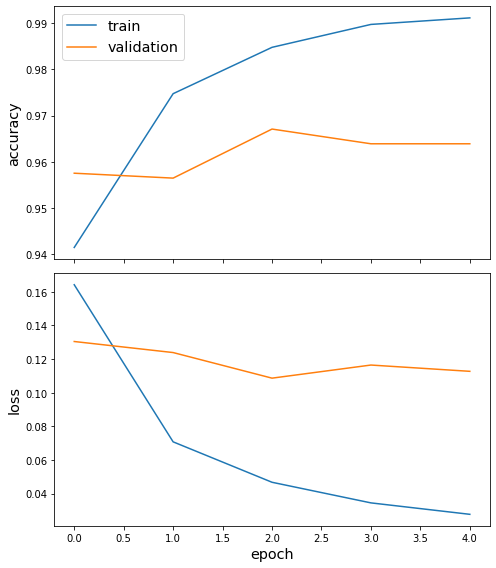

In [11]:
plot_history(history)

### Validation

In [12]:
del data

In [13]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        Blur(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.9; nms_overlap=0.4

In [14]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/blur/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt


  2%|▏         | 1/66 [00:03<03:18,  3.06s/it]

18


  3%|▎         | 2/66 [00:04<02:48,  2.63s/it]

9


  5%|▍         | 3/66 [00:06<02:26,  2.33s/it]

7


  6%|▌         | 4/66 [00:07<02:12,  2.13s/it]

8


  8%|▊         | 5/66 [00:09<02:01,  1.99s/it]

11


  9%|▉         | 6/66 [00:11<01:53,  1.88s/it]

5


 11%|█         | 7/66 [00:12<01:47,  1.82s/it]

18


 12%|█▏        | 8/66 [00:14<01:42,  1.77s/it]

17


 14%|█▎        | 9/66 [00:16<01:38,  1.73s/it]

12


 15%|█▌        | 10/66 [00:17<01:35,  1.70s/it]

33


 17%|█▋        | 11/66 [00:19<01:32,  1.68s/it]

14


 18%|█▊        | 12/66 [00:21<01:30,  1.67s/it]

55


 20%|█▉        | 13/66 [00:22<01:27,  1.66s/it]

18


 21%|██        | 14/66 [00:24<01:26,  1.66s/it]

25


 23%|██▎       | 15/66 [00:26<01:24,  1.65s/it]

9


 24%|██▍       | 16/66 [00:27<01:22,  1.65s/it]

6


 26%|██▌       | 17/66 [00:29<01:20,  1.65s/it]

25


 27%|██▋       | 18/66 [00:30<01:18,  1.64s/it]

6


 29%|██▉       | 19/66 [00:32<01:17,  1.64s/it]

5


 30%|███       | 20/66 [00:34<01:15,  1.64s/it]

21


 32%|███▏      | 21/66 [00:35<01:13,  1.64s/it]

12


 33%|███▎      | 22/66 [00:37<01:12,  1.64s/it]

4


 35%|███▍      | 23/66 [00:39<01:10,  1.64s/it]

65


 36%|███▋      | 24/66 [00:40<01:08,  1.64s/it]

11


 38%|███▊      | 25/66 [00:42<01:07,  1.64s/it]

16


 39%|███▉      | 26/66 [00:44<01:05,  1.63s/it]

18


 41%|████      | 27/66 [00:45<01:03,  1.63s/it]

10


 42%|████▏     | 28/66 [00:47<01:01,  1.63s/it]

28


 44%|████▍     | 29/66 [00:48<01:00,  1.63s/it]

4


 45%|████▌     | 30/66 [00:50<00:58,  1.63s/it]

2


 47%|████▋     | 31/66 [00:52<00:57,  1.64s/it]

21


 48%|████▊     | 32/66 [00:53<00:55,  1.63s/it]

6


 50%|█████     | 33/66 [00:55<00:53,  1.63s/it]

1


 52%|█████▏    | 34/66 [00:57<00:52,  1.63s/it]

10


 53%|█████▎    | 35/66 [00:58<00:50,  1.63s/it]

25


 55%|█████▍    | 36/66 [01:00<00:48,  1.63s/it]

12


 56%|█████▌    | 37/66 [01:02<00:48,  1.69s/it]

7


 58%|█████▊    | 38/66 [01:03<00:46,  1.67s/it]

4


 59%|█████▉    | 39/66 [01:05<00:44,  1.66s/it]

9


 61%|██████    | 40/66 [01:07<00:43,  1.66s/it]

6


 62%|██████▏   | 41/66 [01:08<00:41,  1.65s/it]

6


 64%|██████▎   | 42/66 [01:10<00:39,  1.65s/it]

22


 65%|██████▌   | 43/66 [01:12<00:37,  1.65s/it]

47


 67%|██████▋   | 44/66 [01:13<00:36,  1.65s/it]

10


 68%|██████▊   | 45/66 [01:15<00:34,  1.65s/it]

2


 70%|██████▉   | 46/66 [01:16<00:32,  1.64s/it]

5


 71%|███████   | 47/66 [01:18<00:31,  1.65s/it]

12


 73%|███████▎  | 48/66 [01:20<00:29,  1.64s/it]

31


 74%|███████▍  | 49/66 [01:21<00:27,  1.64s/it]

58


 76%|███████▌  | 50/66 [01:23<00:26,  1.65s/it]

14


 77%|███████▋  | 51/66 [01:25<00:24,  1.65s/it]

6


 79%|███████▉  | 52/66 [01:26<00:23,  1.65s/it]

29


 80%|████████  | 53/66 [01:28<00:21,  1.65s/it]

7


 82%|████████▏ | 54/66 [01:30<00:19,  1.65s/it]

20


 83%|████████▎ | 55/66 [01:31<00:18,  1.65s/it]

34


 85%|████████▍ | 56/66 [01:33<00:16,  1.65s/it]

37


 86%|████████▋ | 57/66 [01:35<00:14,  1.64s/it]

2


 88%|████████▊ | 58/66 [01:36<00:13,  1.64s/it]

9


 89%|████████▉ | 59/66 [01:38<00:11,  1.64s/it]

50


 91%|█████████ | 60/66 [01:40<00:09,  1.64s/it]

3


 92%|█████████▏| 61/66 [01:41<00:08,  1.65s/it]

2


 94%|█████████▍| 62/66 [01:43<00:06,  1.65s/it]

29


 95%|█████████▌| 63/66 [01:44<00:04,  1.65s/it]

17


 97%|█████████▋| 64/66 [01:46<00:03,  1.65s/it]

11


 98%|█████████▊| 65/66 [01:48<00:01,  1.65s/it]

9


100%|██████████| 66/66 [01:49<00:00,  1.67s/it]

9



Precision: 0.089
Recall: 0.706
F1Score: 0.157
